In [1]:
from IPython.display import clear_output
!pip install cleverhans
clear_output()

In [2]:
import numpy as np
from tqdm import tqdm
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from torch.optim.lr_scheduler import StepLR

import torchvision.transforms as transforms
import torchvision.datasets as datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_transform = transforms.Compose([transforms.ToTensor()])

train_set = datasets.CIFAR10(root='../data/', train=True, download=True, transform=train_transform)
print(train_set.data.shape)
print(train_set.data.mean(axis=(0, 1, 2)) / 255)
print(train_set.data.std(axis=(0, 1, 2)) / 255)

100%|██████████| 170498071/170498071 [00:04<00:00, 34487618.66it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data/
(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [4]:
batch_size = 128
mean       = [0.49139968, 0.48215841, 0.44653091]
std        = [0.24703223, 0.24348513, 0.26158784]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

In [5]:
def denormalize(img, mean, std):
    img = img.numpy().transpose((1, 2, 0))
    img = img * std + mean
    return np.clip(img, 0, 1)

def show_samples(data_loader):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images[:5]
    labels = labels[:5]
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        img = denormalize(images[i], mean, std)
        ax.imshow(img)
        ax.set_title(f"{CLASSES[labels[i].item()]}", fontsize=20)
        ax.axis("off")
    plt.show()

def show_adv_images_with_labels(adv_examples, true_labels, pred_labels_orig, pred_labels_adv):
    orig_images, adv_images = adv_examples[0]  # Example batch
    fig, axes = plt.subplots(3, 5, figsize=(15, 8))
    for i in range(5):
        orig = denormalize(orig_images[i].detach().cpu(), mean, std)
        adv = denormalize(adv_images[i].detach().cpu(), mean, std)
        diff = np.abs(adv - orig)

        true_label = CLASSES[true_labels[i]]
        orig_pred_label = CLASSES[pred_labels_orig[i]]
        adv_pred_label = CLASSES[pred_labels_adv[i]]

        axes[0, i].imshow(orig)
        axes[0, i].set_title(f"True: {true_label}\nPred: {orig_pred_label}")
        axes[0, i].axis("off")
        axes[1, i].imshow(adv)
        axes[1, i].set_title(f"Adversarial\nPred: {adv_pred_label}")
        axes[1, i].axis("off")
        axes[2, i].imshow(diff)
        axes[2, i].set_title("Difference")
        axes[2, i].axis("off")
    plt.tight_layout()
    plt.show()

def visualize_adversarial_samples(generator, test_loader):
    generator.eval()

    images, labels = next(iter(test_loader))
    images, labels = images[:5].to(device), labels[:5].to(device)
    with torch.no_grad():
        perturbations = generator(images)
        adv_images = torch.clamp(images + perturbations, -1, 1)

    images = images.cpu()
    adv_images = adv_images.cpu()
    perturbations = perturbations.cpu()

    fig, axes = plt.subplots(3, 5, figsize=(15, 8))
    for i in range(5):
        axes[0, i].imshow(denormalize(images[i], mean, std))
        axes[0, i].set_title(f"Original: {CLASSES[labels[i]]}")
        axes[0, i].axis("off")
        axes[1, i].imshow(denormalize(adv_images[i], mean, std))
        axes[1, i].set_title("Adversarial")
        axes[1, i].axis("off")
        axes[2, i].imshow(denormalize(perturbations[i], mean, std), cmap="seismic")
        axes[2, i].set_title("Perturbation")
        axes[2, i].axis("off")
    plt.tight_layout()
    plt.show()

# def plot_losses(epochs, g_losses, d_losses, g_accuracies):
#     actual_epochs = len(g_losses)  # Number of completed epochs
#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(range(1, actual_epochs + 1), g_losses, label='Generator Loss', color='blue')
#     plt.plot(range(1, actual_epochs + 1), d_losses, label='Discriminator Loss', color='red')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Generator and Discriminator Losses')
#     plt.legend()
#     plt.subplot(1, 2, 2)
#     plt.plot(range(1, actual_epochs + 1), g_accuracies, label='Generator Accuracy', color='green')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.title('Generator Fooling Accuracy')
#     plt.legend()    
#     plt.tight_layout()
#     plt.show()
#     import matplotlib.pyplot as plt

def plot_losses(epochs, g_losses, d_losses, g_accuracies, model_accuracies, 
                attack_success_rates, val_g_losses, val_d_losses, 
                val_g_accuracies, val_model_accuracies, val_attack_success_rates):
    
    actual_epochs = len(g_losses)    
    plt.figure(figsize=(18, 10))
    
    plt.subplot(2, 3, 1)
    plt.plot(range(1, actual_epochs + 1), g_losses, label='Generator Loss', color='blue')
    plt.plot(range(1, actual_epochs + 1), d_losses, label='Discriminator Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    
    plt.subplot(2, 3, 2)
    plt.plot(range(1, actual_epochs + 1), g_accuracies, label='Generator Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Generator Fooling Accuracy')
    plt.legend()
    
    plt.subplot(2, 3, 3)
    plt.plot(range(1, actual_epochs + 1), model_accuracies, label='Model Accuracy', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    
    plt.subplot(2, 3, 4)
    plt.plot(range(1, actual_epochs + 1), attack_success_rates, label='Attack Success Rate', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Success Rate')
    plt.title('Attack Success Rates')
    plt.legend()
    
    plt.subplot(2, 3, 5)
    plt.plot(range(1, actual_epochs + 1), val_g_losses, label='Validation Generator Loss', color='blue')
    plt.plot(range(1, actual_epochs + 1), val_d_losses, label='Validation Discriminator Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Generator and Discriminator Losses')
    plt.legend()
    
    plt.subplot(2, 3, 6)
    plt.plot(range(1, actual_epochs + 1), val_g_accuracies, label='Validation Generator Accuracy', color='green')
    plt.plot(range(1, actual_epochs + 1), val_model_accuracies, label='Validation Model Accuracy', color='purple')
    plt.plot(range(1, actual_epochs + 1), val_attack_success_rates, label='Validation Attack Success Rate', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy / Success Rate')
    plt.title('Validation Metrics')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def plot_confidence_histograms(target_model, test_loader, generator):
    normal_confidences = []
    adversarial_confidences = []

    generator.eval()
    target_model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            perturbations = generator(images)
            adv_images = torch.clamp(images + perturbations, -1, 1)
            # Get softmax confidence for normal and adversarial images
            normal_outputs = torch.softmax(target_model(images), dim=1)
            adv_outputs = torch.softmax(target_model(adv_images), dim=1)

            normal_confidences.extend(normal_outputs.max(1)[0].cpu().numpy())
            adversarial_confidences.extend(adv_outputs.max(1)[0].cpu().numpy())
    plt.figure(figsize=(10, 5))
    plt.hist(adversarial_confidences, bins=20, alpha=0.7, label="Adversarial Samples", color="red")
    plt.hist(normal_confidences, bins=20, alpha=0.7, label="Normal Samples", color="blue")
    plt.xlabel("Confidence")
    plt.ylabel("Frequency")
    plt.title("Confidence Histogram: Normal vs Adversarial")
    plt.legend()
    plt.show()

In [6]:
def attack_success_rate(model, adv_examples):
    total, success = 0, 0
    model.eval()
    for orig_images, adv_images in adv_examples:
        with torch.no_grad():
            orig_preds = model(orig_images).argmax(dim=1)
            adv_preds = model(adv_images).argmax(dim=1)
            success += (orig_preds != adv_preds).sum().item()
            total += orig_images.size(0)
    return success / total

def calculate_attack_success(target_model, test_loader, generator):
    overall_success = 0
    per_class_success = np.zeros(10)
    per_class_count = np.zeros(10)

    generator.eval()
    target_model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            perturbations = generator(images)
            adv_images = torch.clamp(images + perturbations, -1, 1)
            # Get predictions on adversarial samples
            adv_outputs = target_model(adv_images)
            _, adv_preds = adv_outputs.max(1)
            fooled = (adv_preds != labels).cpu().numpy()
            overall_success += fooled.sum()
            for label, is_fooled in zip(labels.cpu().numpy(), fooled):
                per_class_count[label] += 1
                per_class_success[label] += is_fooled
    overall_rate = overall_success / sum(per_class_count)
    per_class_rate = per_class_success / per_class_count
    return overall_rate, per_class_rate

def calculate_targeted_attack_success(target_model, test_loader, generator, target_class):
    overall_success = 0
    per_class_success = np.zeros(10)
    per_class_count = np.zeros(10)

    generator.eval()
    target_model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            perturbations = generator(images)
            adv_images = torch.clamp(images + perturbations, -1, 1)

            # Get predictions on adversarial samples
            adv_outputs = target_model(adv_images)
            _, adv_preds = adv_outputs.max(1)

            # Check if target model was successfully targeted
            targeted = (adv_preds == target_class).cpu().numpy()
            overall_success += targeted.sum()

            # Update per-class metrics
            for label, is_targeted in zip(labels.cpu().numpy(), targeted):
                per_class_count[label] += 1
                per_class_success[label] += is_targeted

    overall_rate = overall_success / sum(per_class_count)
    per_class_rate = per_class_success / per_class_count

    return overall_rate, per_class_rate

In [7]:
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
print(dataset.data.shape)
print(dataset.data.mean(axis=(0, 1, 2)) / 255)
print(dataset.data.std(axis=(0, 1, 2)) / 255)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Split training dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 35077193.40it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]
Files already downloaded and verified


In [8]:
# show_samples(train_loader)
# show_samples(val_loader)
# show_samples(test_loader)

In [9]:
target_model = torch.hub.load(
    "chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True
).to(device)
target_model.eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 30.1MB/s

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [10]:
# # Evaluate accuracy on test set

# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = target_model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f"Test Accuracy: {100 * correct / total}%")

# ##################################################################### #

# # Generate adversarial images using FGSM
# epsilon = 0.01

# adv_examples = []
# true_labels = []
# pred_labels_orig = []
# pred_labels_adv = []

# target_model.eval()
# for images, labels in test_loader:
#     images, labels = images.to(device), labels.to(device)

#     adv_images = fast_gradient_method(target_model, images, epsilon, norm=np.inf)
#     adv_examples.append((images, adv_images))
#     true_labels.extend(labels.cpu().numpy())
    
#     with torch.no_grad():
#         orig_preds = target_model(images).argmax(dim=1)
#         adv_preds = target_model(adv_images).argmax(dim=1)
#         pred_labels_orig.extend(orig_preds.cpu().numpy())
#         pred_labels_adv.extend(adv_preds.cpu().numpy())

# success_rate = attack_success_rate(target_model, adv_examples)
# print(f"Attack Success Rate: {success_rate * 100:.2f}%")

# ##################################################################### #

# show_samples(train_loader)
# show_samples(val_loader)
# show_samples(test_loader)

# show_adv_images_with_labels(adv_examples, true_labels, pred_labels_orig, pred_labels_adv)

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512)
        )
        self.decoder = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.Dropout(0.5),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # Fixed input channels to 256
            nn.BatchNorm2d(128),
            nn.Dropout(0.5),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Fixed input channels to 128
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # Fixed input channels to 64
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(16),  # Fixed input channels to match previous Conv2d output
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.InstanceNorm2d(32), ###### , negative_slope=0.2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(), # x = x.view(x.size(0), -1)  
            nn.Linear(4 * 4 * 32, 1)  # Linear layer for final output
        )

    def forward(self, x):
        return self.model(x).view(-1)

In [12]:
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         # Encoder
#         self.enc1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
#         self.enc2 = self._encoder_block(64, 128)
#         self.enc3 = self._encoder_block(128, 256)
#         self.enc4 = self._encoder_block(256, 512)
#         # Decoder
#         self.dec1 = self._decoder_block(512, 256)
#         self.dec2 = self._decoder_block(512, 128)
#         self.dec3 = self._decoder_block(256, 64)
#         self.dec4 = nn.Sequential(
#             nn.ReLU(True),
#             nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.Tanh()
#         )

#     def _encoder_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.LeakyReLU(0.2, True),
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(out_channels)
#         )

#     def _decoder_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.ReLU(True),
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.Dropout(0.5)
#         )

#     def encoder(self, x):
#         e1 = self.enc1(x)
#         e2 = self.enc2(e1)
#         e3 = self.enc3(e2)
#         e4 = self.enc4(e3)
#         return e1, e2, e3, e4

#     def decoder(self, e1, e2, e3, e4):
#         d1 = self.dec1(e4)
#         d2 = self.dec2(torch.cat([d1, e3], 1))
#         d3 = self.dec3(torch.cat([d2, e2], 1))
#         d4 = self.dec4(torch.cat([d3, e1], 1))
#         return d4

#     def forward(self, x):
#         e1, e2, e3, e4 = self.encoder(x)
#         decoded = self.decoder(e1, e2, e3, e4)
#         return decoded


# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()

#         self.conv1 = nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1)
#         self.conv2 = self._discriminator_block(8, 16)
#         self.conv3 = self._discriminator_block(16, 32)
#         self.fc = nn.Linear(4 * 4 * 32, 1)

#     def _discriminator_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
#             nn.InstanceNorm2d(out_channels),
#             nn.LeakyReLU(0.2, True)
#         )

#     def encoder(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         return x

#     def decoder(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

In [13]:
# class LossFunctions:
#     @staticmethod
#     def gan_loss(discriminator, original_images, perturbations):
#         mse_loss = nn.MSELoss()
#         # Discriminator outputs for real images
#         real_preds = discriminator(original_images)
#         real_targets = torch.ones_like(real_preds)  # Targets for real images are 1
#         real_loss = mse_loss(real_preds, real_targets)
#         # print(f"real_loss: {real_loss}")
#         # Discriminator outputs for fake images
#         fake_images = original_images + perturbations
#         fake_preds = discriminator(fake_images)
#         fake_targets = torch.zeros_like(fake_preds)  # Targets for fake images are 0
#         fake_loss = mse_loss(fake_preds, fake_targets)
#         # print(f"fake_loss: {fake_loss}")
#         # Combine real and fake losses
#         total_gan_loss = real_loss + fake_loss
#         # print(f"total_gan_loss: {total_gan_loss}")
#         return total_gan_loss

#     @staticmethod
#     def adversarial_loss(target_model, adv_images, target_labels):
#         outputs = target_model(adv_images)
#         return F.cross_entropy(outputs, target_labels)

#     @staticmethod
#     def hinge_loss(perturbations, c):
#         norm = torch.norm(perturbations.view(perturbations.size(0), -1), dim=1)  # L2 norm
#         hinge = F.relu(norm - c)
#         return torch.mean(hinge)

#     @staticmethod
#     def total_loss(discriminator, target_model, alpha, beta, c, original_images, perturbations, target_labels):
#         adv_images = torch.clamp(original_images + perturbations, -1, 1)
#         l_gan = LossFunctions.gan_loss(discriminator, original_images, perturbations)
#         l_adv = LossFunctions.adversarial_loss(target_model, adv_images, target_labels)
#         l_hinge = LossFunctions.hinge_loss(perturbations, c)
#         return l_adv + alpha * l_gan + beta * l_hinge

In [14]:
def adv_loss(logits, target, num_classes=10, kappa=0):
    target_one_hot = torch.eye(num_classes).type(logits.type())[target.long()]
    real = torch.sum(target_one_hot * logits, 1)
    other = torch.max((1 - target_one_hot) * logits - (target_one_hot * 10000), 1)[0]
    kappa = torch.zeros_like(other).fill_(kappa)
    return torch.sum(torch.max(real - other, kappa))

criterion_gan = nn.MSELoss()
criterion_adv = adv_loss
criterion_hinge = lambda perturb: torch.mean(torch.clamp(torch.norm(perturb.view(perturb.size(0), -1), dim=1) - c, min=0))

def attack_success(model, adversarial_images, labels):
    with torch.no_grad():
        adv_preds = model(adversarial_images).argmax(dim=1)
        success = (labels != adv_preds).sum().item()
    return success

def train_epoch(epoch, G, D, train_loader, optimizer_G, optimizer_D, target_model, alpha, beta):
    G.train()
    D.train()
    train_g_loss, train_d_loss, train_attack_success_counts = 0, 0, 0
    tepoch = tqdm(train_loader, unit="batch", desc=f"Training Epoch {epoch+1}/{epochs}", ncols=100, leave=False)
    for batch_idx, (images, labels) in enumerate(tepoch):
        images, labels = images.to(device), labels.to(device)
        batch_size = images.size(0)

        perturbations = G(images)
        adversarial_images = images + perturbations

        optimizer_D.zero_grad()
        real_loss = criterion_gan(D(images), torch.ones(batch_size, device=device))
        fake_loss = criterion_gan(D(adversarial_images.detach()), torch.zeros(batch_size, device=device))
        #########################################################################################################
        # real_loss = criterion_gan(D(images), torch.ones((batch_size, 1), device=device))
        # fake_loss = criterion_gan(D(adversarial_images.detach()), torch.zeros((batch_size, 1), device=device))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        adv_loss_value = criterion_adv(target_model(adversarial_images), labels)/4
        gan_loss = criterion_gan(D(adversarial_images), torch.ones(batch_size, device=device))
        hinge_loss = criterion_hinge(perturbations)
        g_loss = alpha * gan_loss + beta * hinge_loss + adv_loss_value
        g_loss.backward()
        optimizer_G.step()

        train_g_loss += g_loss.item()
        train_d_loss += d_loss.item()
        train_attack_success_counts += attack_success(target_model, adversarial_images, labels)
        tepoch.set_postfix({'Batch': batch_idx + 1, 'G_Loss': g_loss.item(), 'D_Loss': d_loss.item()})

    train_g_loss /= len(train_loader)
    train_d_loss /= len(train_loader)
    train_attack_success_rate = train_attack_success_counts / len(train_dataset)
    return train_g_loss, train_d_loss, train_attack_success_rate

def validate_epoch(G, D, val_loader, target_model, alpha, beta):
    G.eval()
    D.eval()
    val_g_loss, val_d_loss, val_attack_success_counts = 0, 0, 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            batch_size = val_images.size(0)

            val_perturbations = G(val_images)
            val_adversarial_images = val_images + val_perturbations

            val_adv_loss_value = criterion_adv(target_model(val_adversarial_images), val_labels)/4
            val_gan_loss = criterion_gan(D(val_adversarial_images), torch.ones(batch_size, device=device)) 
            val_hinge_loss = criterion_hinge(val_perturbations)
            val_g_loss_batch = alpha * val_gan_loss + beta * val_hinge_loss + val_adv_loss_value

            val_real_loss = criterion_gan(D(val_images), torch.ones(batch_size, device=device))
            val_fake_loss = criterion_gan(D(val_adversarial_images), torch.zeros(batch_size, device=device))
            val_d_loss_batch = val_real_loss + val_fake_loss

            val_g_loss += val_g_loss_batch.item()
            val_d_loss += val_d_loss_batch.item()
            val_attack_success_counts += attack_success(target_model, val_adversarial_images, val_labels)

    val_g_loss /= len(val_loader)
    val_d_loss /= len(val_loader)
    val_attack_success_rate = val_attack_success_counts / len(val_dataset)
    return val_g_loss, val_d_loss, val_attack_success_rate

In [15]:
G = Generator().to(device)
D = Discriminator().to(device)

epochs = 50 
lr = 0.001
alpha = 1.0 # param alpha: Weight for adversarial loss (LGAN) 
beta = 10.0 # param beta: Weight for hinge loss (Lhinge)
c = 8/255   # param c: Hinge loss bound
patience = 10
8 / (255 * torch.tensor(std).max().item())
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999)) # , betas=(0.5, 0.999)
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999)) # , betas=(0.5, 0.999)

g_scheduler = StepLR(optimizer_G, step_size=5, gamma=0.5)
d_scheduler = StepLR(optimizer_D, step_size=5, gamma=0.5)

In [16]:
best_val_loss = float('inf')
patience_counter = 0
g_losses, d_losses, g_accuracies = [], [], []
val_g_losses, val_d_losses = [], []
attack_success_rates, val_attack_success_rates = [], []
# g_accuracies, val_g_accuracies = [], []
# model_accuracies, val_model_accuracies = [], []

for epoch in range(epochs):
    g_loss, d_loss, attack_success_rate = train_epoch(
        epoch, G, D, train_loader, optimizer_G, optimizer_D, target_model, alpha, beta
    )
    g_losses.append(g_loss)
    d_losses.append(d_loss)
    attack_success_rates.append(attack_success_rate)
    
    val_g_loss, val_d_loss, val_attack_success_rate = validate_epoch(
        G, D, val_loader, target_model, alpha, beta
    )
    val_g_losses.append(val_g_loss)
    val_d_losses.append(val_d_loss)
    val_attack_success_rates.append(val_attack_success_rate)
    
    print(f"Epoch {epoch+1}/{epochs} | g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}, val_g_loss: {val_g_loss:.4f}, val_d_loss: {val_d_loss:.4f}, attack_success_rate: {attack_success_rate:.4f}, val_attack_success_rate: {val_attack_success_rate:.4f}")    
    
    g_scheduler.step()
    print(f"Learning rate for generator: {g_scheduler.get_last_lr()[0]}") 
    d_scheduler.step()
    print(f"Learning rate for discriminator: {d_scheduler.get_last_lr()[0]}")

    if val_g_loss < best_val_loss:
        best_val_loss = val_g_loss
        patience_counter = 0
        torch.save(G.state_dict(), 'best_generator.pth')
        torch.save(D.state_dict(), 'best_discriminator.pth')
    else:
        print(f"Patience counter: {patience_counter + 1}/{patience}")
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break


Epoch 1/50 | g_loss: 112.9722, d_loss: 0.1189, val_g_loss: 87.3927, val_d_loss: 0.4363, attack_success_rate: 0.7877, val_attack_success_rate: 0.8305


Epoch 2/50 | g_loss: 83.0137, d_loss: 0.0090, val_g_loss: 71.2765, val_d_loss: 0.2422, attack_success_rate: 0.8082, val_attack_success_rate: 0.8297


Epoch 3/50 | g_loss: 72.7268, d_loss: 0.0027, val_g_loss: 67.4683, val_d_loss: 0.1952, attack_success_rate: 0.8313, val_attack_success_rate: 0.8238


Epoch 4/50 | g_loss: 67.0452, d_loss: 0.0020, val_g_loss: 62.7777, val_d_loss: 0.1292, attack_success_rate: 0.8470, val_attack_success_rate: 0.8516


Epoch 5/50 | g_loss: 63.0805, d_loss: 0.0150, val_g_loss: 85.1201, val_d_loss: 0.1799, attack_success_rate: 0.8577, val_attack_success_rate: 0.7072
Patience counter: 1/10


Epoch 6/50 | g_loss: 58.9143, d_loss: 0.0007, val_g_loss: 57.7345, val_d_loss: 0.1595, attack_success_rate: 0.8691, val_attack_success_rate: 0.8906


Epoch 7/50 | g_loss: 56.8994, d_loss: 0.0006, val_g_loss: 55.5416, val_d_loss: 0.1454, attack_success_rate: 0.8744, val_attack_success_rate: 0.8816


Epoch 8/50 | g_loss: 55.4877, d_loss: 0.0005, val_g_loss: 55.2459, val_d_loss: 0.1251, attack_success_rate: 0.8783, val_attack_success_rate: 0.8682


Epoch 9/50 | g_loss: 54.3496, d_loss: 0.0004, val_g_loss: 56.9176, val_d_loss: 0.1209, attack_success_rate: 0.8833, val_attack_success_rate: 0.8675
Patience counter: 1/10


Epoch 10/50 | g_loss: 53.3944, d_loss: 0.0003, val_g_loss: 54.1974, val_d_loss: 0.1695, attack_success_rate: 0.8858, val_attack_success_rate: 0.8925


Epoch 11/50 | g_loss: 50.0983, d_loss: 0.0003, val_g_loss: 53.4810, val_d_loss: 0.1466, attack_success_rate: 0.8966, val_attack_success_rate: 0.8818


Epoch 12/50 | g_loss: 48.9109, d_loss: 0.0003, val_g_loss: 53.0054, val_d_loss: 0.1849, attack_success_rate: 0.8996, val_attack_success_rate: 0.8807


Epoch 13/50 | g_loss: 47.9304, d_loss: 0.0002, val_g_loss: 52.5413, val_d_loss: 0.1688, attack_success_rate: 0.9014, val_attack_success_rate: 0.9027


Epoch 14/50 | g_loss: 47.0613, d_loss: 0.0002, val_g_loss: 53.3669, val_d_loss: 0.1733, attack_success_rate: 0.9052, val_attack_success_rate: 0.8845
Patience counter: 1/10


Epoch 15/50 | g_loss: 46.1780, d_loss: 0.0002, val_g_loss: 52.7480, val_d_loss: 0.1960, attack_success_rate: 0.9079, val_attack_success_rate: 0.8952
Patience counter: 2/10


Epoch 16/50 | g_loss: 44.3965, d_loss: 0.0002, val_g_loss: 51.8428, val_d_loss: 0.1646, attack_success_rate: 0.9131, val_attack_success_rate: 0.8798


Epoch 17/50 | g_loss: 43.3466, d_loss: 0.0002, val_g_loss: 51.9663, val_d_loss: 0.1962, attack_success_rate: 0.9153, val_attack_success_rate: 0.8817
Patience counter: 1/10


Epoch 18/50 | g_loss: 42.7436, d_loss: 0.0002, val_g_loss: 52.2282, val_d_loss: 0.2065, attack_success_rate: 0.9175, val_attack_success_rate: 0.8699
Patience counter: 2/10


Epoch 19/50 | g_loss: 42.1146, d_loss: 0.0001, val_g_loss: 52.3322, val_d_loss: 0.2424, attack_success_rate: 0.9195, val_attack_success_rate: 0.8785
Patience counter: 3/10


Epoch 20/50 | g_loss: 41.7403, d_loss: 0.0001, val_g_loss: 52.8827, val_d_loss: 0.2124, attack_success_rate: 0.9208, val_attack_success_rate: 0.8602
Patience counter: 4/10


Epoch 21/50 | g_loss: 40.5534, d_loss: 0.0001, val_g_loss: 52.8476, val_d_loss: 0.2085, attack_success_rate: 0.9225, val_attack_success_rate: 0.8591
Patience counter: 5/10


Epoch 22/50 | g_loss: 40.0149, d_loss: 0.0001, val_g_loss: 52.1251, val_d_loss: 0.2344, attack_success_rate: 0.9238, val_attack_success_rate: 0.8673
Patience counter: 6/10


Epoch 23/50 | g_loss: 39.5267, d_loss: 0.0001, val_g_loss: 52.7715, val_d_loss: 0.2513, attack_success_rate: 0.9253, val_attack_success_rate: 0.8636
Patience counter: 7/10


Epoch 24/50 | g_loss: 39.2128, d_loss: 0.0001, val_g_loss: 52.6570, val_d_loss: 0.2575, attack_success_rate: 0.9257, val_attack_success_rate: 0.8633
Patience counter: 8/10


Epoch 25/50 | g_loss: 38.8495, d_loss: 0.0001, val_g_loss: 52.6702, val_d_loss: 0.2963, attack_success_rate: 0.9268, val_attack_success_rate: 0.8612
Patience counter: 9/10


Epoch 26/50 | g_loss: 38.3381, d_loss: 0.0001, val_g_loss: 52.8999, val_d_loss: 0.2756, attack_success_rate: 0.9297, val_attack_success_rate: 0.8557
Patience counter: 10/10
Early stopping triggered after 26 epochs.


In [17]:
# best_val_loss = float('inf')
# patience_counter = 0
# g_losses, d_losses, g_accuracies = [], [], []
# val_g_losses, val_d_losses = [], []
# attack_success_rates, val_attack_success_rates = [], []
# # g_accuracies, val_g_accuracies = [], []
# # model_accuracies, val_model_accuracies = [], []
# for epoch in range(epochs):
#     g_loss, d_loss, attack_success_rate = train_epoch(
#         epoch, G, D, train_loader, optimizer_G, optimizer_D, target_model, alpha, beta
#     )
#     g_losses.append(g_loss)
#     d_losses.append(d_loss)
#     attack_success_rates.append(attack_success_rate)
    
#     val_g_loss, val_d_loss, val_attack_success_rate = validate_epoch(
#         G, D, val_loader, target_model, alpha, beta
#     )
#     val_g_losses.append(val_g_loss)
#     val_d_losses.append(val_d_loss)
#     val_attack_success_rates.append(val_attack_success_rate)
    
#     print(f"Epoch {epoch+1}/{epochs} | g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}, val_g_loss: {val_g_loss:.4f}, val_d_loss: {val_d_loss:.4f}, attack_success_rate: {attack_success_rate:.4f}, val_attack_success_rate: {val_attack_success_rate:.4f}")    
#     if val_g_loss < best_val_loss:
#         best_val_loss = val_g_loss
#         patience_counter = 0
#         torch.save(G.state_dict(), 'best_generator.pth')
#         torch.save(D.state_dict(), 'best_discriminator.pth')
#     else:
#         print(f"Patience counter: {patience_counter + 1}/{patience}")
#         patience_counter += 1

#     if patience_counter >= patience:
#         print(f"Early stopping triggered after {epoch + 1} epochs.")
#         print("Early stopping triggered.")
#         break

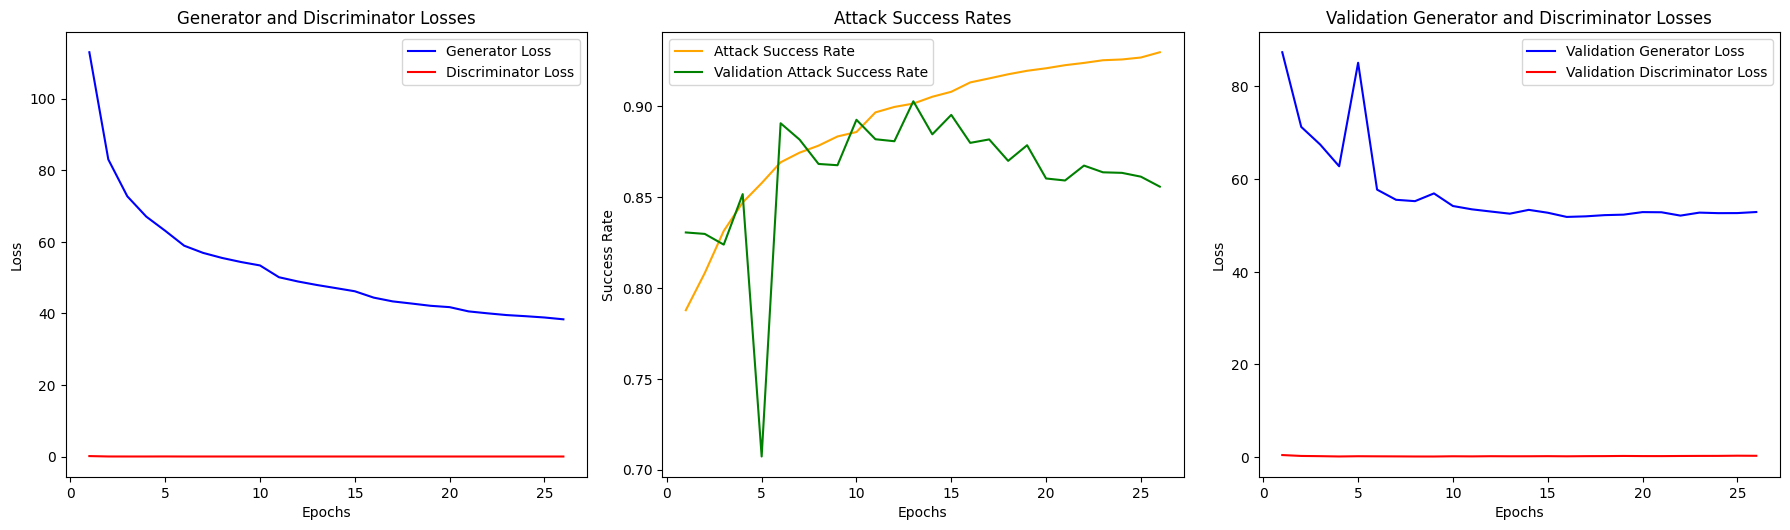

In [18]:
actual_epochs = len(g_losses)    
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.plot(range(1, actual_epochs + 1), g_losses, label='Generator Loss', color='blue')
plt.plot(range(1, actual_epochs + 1), d_losses, label='Discriminator Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(range(1, actual_epochs + 1), attack_success_rates, label='Attack Success Rate', color='orange')
plt.plot(range(1, actual_epochs + 1), val_attack_success_rates, label='Validation Attack Success Rate', color='green')
plt.xlabel('Epochs')
plt.ylabel('Success Rate')
plt.title('Attack Success Rates')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(range(1, actual_epochs + 1), val_g_losses, label='Validation Generator Loss', color='blue')
plt.plot(range(1, actual_epochs + 1), val_d_losses, label='Validation Discriminator Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Generator and Discriminator Losses')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# def train_gan(
#     G, D, target_model, train_loader, val_loader,
#     epochs, optimizer_G, optimizer_D, c, alpha, beta, 
#     g_scheduler, d_scheduler, patience
# ):
#     g_losses, d_losses, g_accuracies = [], [], []
#     val_g_losses, val_d_losses, val_g_accuracies = [], [], []
#     model_accuracies, attack_success_rates = [], []
#     val_model_accuracies, val_attack_success_rates = [], []
#     best_g_loss, best_d_loss = float('inf'), float('inf')
#     epochs_no_improve = 0

#     for epoch in range(epochs):
#         correct_adv, correct_benign, total_samples = 0, 0, 0
#         g_loss_epoch, d_loss_epoch = 0.0, 0.0

#         tepoch = tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}", ncols=100, leave=False)

#         for batch_idx, (images, labels) in enumerate(tepoch):
#             images, labels = images.to(device), labels.to(device)
#             G.train()
#             D.train()
#             target_model.eval()
        
#             """
#             Generator Update
#             """
#             optimizer_G.zero_grad()
#             perturbations = G(images)  # Recompute perturbations for generator update
#             g_loss = LossFunctions.total_loss(
#                 D, target_model,
#                 alpha, beta, c, images, perturbations, labels
#             )
#             g_loss.backward()
#             optimizer_G.step()
#             """
#             Discriminator Update
#             """
#             optimizer_D.zero_grad()
#             with torch.no_grad():  # Disable gradient tracking for generator during discriminator update
#                 perturbations = G(images)
#                 adv_images = torch.clamp(images + perturbations, -1, 1)
        
#             d_loss = LossFunctions.gan_loss(D, images, perturbations)
#             d_loss.backward()
#             optimizer_D.step() 

            
#             # Track losses and accuracy
#             g_loss_epoch += g_loss.item()
#             d_loss_epoch += d_loss.item()
        
#             with torch.no_grad():
#                 benign_output = target_model(images)
#                 _, benign_predicted = benign_output.max(1)
#                 adv_output = target_model(adv_images)
#                 _, adv_predicted = adv_output.max(1)
        
#                 correct_benign += (benign_predicted == labels).sum().item()
#                 correct_adv += (adv_predicted != benign_predicted).sum().item()
#                 total_samples += labels.size(0)
        
#             tepoch.set_postfix({'Batch': batch_idx + 1, 'G_Loss': g_loss.item(), 'D_Loss': d_loss.item()})
        
#         g_losses.append(g_loss_epoch / len(train_loader))
#         d_losses.append(d_loss_epoch / len(train_loader))
#         # len(train_loader):313 O total_samples:40000
#         print(f"len(train_loader):{len(train_loader)} O total_samples:{total_samples}")
#         print(f"correct_adv:{correct_adv} O total_samples:{total_samples}")
#         g_accuracies.append(correct_adv / total_samples)
#         model_accuracies.append(correct_benign / total_samples)
#         attack_success_rates.append(correct_adv / total_samples)

#         G.eval()
#         D.eval()
#         target_model.eval()
#         val_g_loss_epoch, val_d_loss_epoch = 0.0, 0.0
#         val_correct_adv, val_correct_benign, val_samples = 0, 0, 0
#         with torch.no_grad():
#             for val_images, val_labels in val_loader:
#                 val_images, val_labels = val_images.to(device), val_labels.to(device)

#                 val_perturbations = G(val_images)
#                 val_adv_images = torch.clamp(val_images + val_perturbations, -1, 1)

#                 val_d_loss = LossFunctions.gan_loss(D, val_images, val_perturbations)
#                 val_g_loss = LossFunctions.total_loss(
#                     D, target_model,
#                     alpha, beta, c, val_images, val_perturbations, val_labels
#                 )

#                 val_g_loss_epoch += val_g_loss.item()
#                 val_d_loss_epoch += val_d_loss.item()

#                 val_benign_output = target_model(val_images)
#                 _, val_benign_predicted = val_benign_output.max(1)
#                 val_adv_output = target_model(val_adv_images)
#                 _, val_adv_predicted = val_adv_output.max(1)

#                 val_correct_benign += (val_benign_predicted == val_labels).sum().item()
#                 val_correct_adv += (val_adv_predicted != val_labels).sum().item()
#                 val_samples += val_labels.size(0)

#         g_scheduler.step()
#         d_scheduler.step()
        
#         val_g_losses.append(val_g_loss_epoch / len(val_loader))
#         val_d_losses.append(val_d_loss_epoch / len(val_loader))
#         val_g_accuracies.append(val_correct_adv / val_samples)
#         val_model_accuracies.append(val_correct_benign / val_samples)
#         val_attack_success_rates.append(val_correct_adv / val_samples)

#         print(f"Epoch [{epoch+1}/{epochs}], "
#               f"Train G_Loss: {g_losses[-1]:.4f}, D_Loss: {d_losses[-1]:.4f}, Model Accuracy: {model_accuracies[-1]:.4f}, "
#               f"Attack Success Rate: {attack_success_rates[-1]:.4f}, "
#               f"Val G_Loss: {val_g_losses[-1]:.4f}, Val D_Loss: {val_d_losses[-1]:.4f}, "
#               f"Val Model Accuracy: {val_model_accuracies[-1]:.4f}, Val Attack Success Rate: {val_attack_success_rates[-1]:.4f}")
#         if val_g_losses[-1] < best_g_loss or val_d_losses[-1] < best_d_loss:
#             best_g_loss = min(val_g_losses[-1], best_g_loss)
#             best_d_loss = min(val_d_losses[-1], best_d_loss)
#             epochs_no_improve = 0
#         else:
#             epochs_no_improve += 1
#             print(f"Epochs without improvement: {epochs_no_improve}/{patience}")
#             if epochs_no_improve >= patience:
#                 print(f"Early stopping triggered after {epoch + 1} epochs.")
#                 break
#     return (g_losses, d_losses, g_accuracies, model_accuracies, attack_success_rates,
#             val_g_losses, val_d_losses, val_g_accuracies, val_model_accuracies, val_attack_success_rates)

# (g_losses, d_losses, g_accuracies, model_accuracies, attack_success_rates, 
#  val_g_losses, val_d_losses, val_g_accuracies, val_model_accuracies, 
#  val_attack_success_rates) = train_gan(
#     G, D, target_model, train_loader, val_loader,
#     epochs, optimizer_G, optimizer_D, c, alpha, beta, 
#     g_scheduler, d_scheduler, patience
# )

# plot_losses(
#     epochs, g_losses, d_losses, g_accuracies, model_accuracies, 
#     attack_success_rates, val_g_losses, val_d_losses, 
#     val_g_accuracies, val_model_accuracies, val_attack_success_rates
# )

In [ ]:
overall_rate, per_class_rate = calculate_attack_success(target_model, test_loader, generator)

print(f"Overall Attack Success Rate: {overall_rate * 100:.2f}%")
for i, class_name in enumerate(CLASSES):
    print(f"Class {class_name}: {per_class_rate[i] * 100:.2f}%")

In [ ]:
visualize_adversarial_samples(generator, test_loader)

In [ ]:
plot_confidence_histograms(target_model, test_loader, generator)

In [ ]:
# def train_gan(
#     generator, discriminator, target_model, train_loader, 
#     epochs, g_optimizer, d_optimizer, c, alpha, beta, 
#     g_scheduler, d_scheduler, patience
# ):
#     g_losses, d_losses, g_accuracies = [], [], []
#     best_g_loss, best_d_loss = float('inf'), float('inf')
#     epochs_no_improve = 0

#     for epoch in range(epochs):
#         correct_adv = 0
#         g_loss_epoch, d_loss_epoch = 0.0, 0.0
#         tepoch = tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}", ncols=100, leave=False)

#         generator.train()
#         discriminator.train()
#         for batch_idx, (images, labels) in enumerate(tepoch):
#             images, labels = images.to(device), labels.to(device)

#             perturbations = generator(images)
#             adv_images = torch.clamp(images + perturbations, -1, 1)

#             d_optimizer.zero_grad()
#             d_loss = LossFunctions.gan_loss(
#                 discriminator, images, perturbations
#             )
#             d_loss.backward()
#             d_optimizer.step()

#             g_optimizer.zero_grad()
#             g_loss = LossFunctions.total_loss(
#                 discriminator, target_model, 
#                 alpha, beta, c, images, perturbations
#             )
#             g_loss.backward()
#             g_optimizer.step()

#             g_loss_epoch += g_loss.item()
#             d_loss_epoch += d_loss.item()
#             adv_output = target_model(adv_images)
#             _, predicted = adv_output.max(1)
#             correct_adv += (predicted != labels).sum().item()
#             tepoch.set_postfix({'Batch': batch_idx + 1, 'G_Loss': g_loss.item(), 'D_Loss': d_loss.item()})

#         g_losses.append(g_loss_epoch / len(train_loader))
#         d_losses.append(d_loss_epoch / len(train_loader))
#         g_accuracies.append(correct_adv / len(train_loader))
        
#         print(f"Epoch [{epoch+1}/{epochs}], Generator Loss: {g_losses[-1]:.4f}, Discriminator Loss: {d_losses[-1]:.4f}, Fooling Accuracy: {g_accuracies[-1]:.4f}")
#         generator.eval()
#         g_scheduler.step()
        
#         discriminator.eval()
#         d_scheduler.step()

#         if g_losses[-1] < best_g_loss or d_losses[-1] < best_d_loss:
#             best_g_loss = min(g_losses[-1], best_g_loss)
#             best_d_loss = min(d_losses[-1], best_d_loss)
#             epochs_no_improve = 0
#         else:
#             print(f"Epochs without improvement: {epochs_no_improve + 1}/{patience}")
#             epochs_no_improve += 1
#             if epochs_no_improve >= patience:
#                 print(f"Early stopping triggered after {epoch + 1} epochs.")
#                 break

#     return g_losses, d_losses, g_accuracies

# g_losses, d_losses, g_accuracies = train_gan(
#     generator, discriminator, target_model, train_loader, 
#     epochs, g_optimizer, d_optimizer, c, alpha, beta, 
#     g_scheduler, d_scheduler, patience
# )

# plot_losses(epochs, g_losses, d_losses, g_accuracies)

In [ ]:
# target_class = 0  # Example: Force adversarial images to be classified as "airplane" (class 0)
# fooling_loss = adv_loss_fn(adv_output, torch.full_like(labels, target_class))

# generator = Generator().to(device)
# discriminator = Discriminator().to(device)

# epochs = 50 
# lr = 0.001
# alpha = 1.0  # Weight for GAN loss
# beta = 10.0  # Weight for hinge loss
# # c = 0.1  # Perturbation bound
# c = 8/255 # Perturbation bound (c) = 8/255 for CIFAR-10

# g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
# d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# g_scheduler = StepLR(g_optimizer, step_size=10, gamma=0.5)
# d_scheduler = StepLR(d_optimizer, step_size=10, gamma=0.5)

# g_losses, d_losses, g_accuracies = train_gan(
#     generator, discriminator, target_model, train_loader, 
#     epochs, g_optimizer, d_optimizer, c, alpha, beta, 
#     g_scheduler, d_scheduler, patience
# )

# plot_losses(epochs, g_losses, d_losses, g_accuracies)
# overall_rate, per_class_rate = calculate_targeted_attack_success(target_model, test_loader, generator, target_class)

# print(f"Overall Targeted Attack Success Rate: {overall_rate * 100:.2f}%")
# for i, class_name in enumerate(CLASSES):
#     print(f"Class {class_name}: {per_class_rate[i] * 100:.2f}%")

# visualize_adversarial_samples(generator, test_loader)
# plot_confidence_histograms(target_model, test_loader, generator)